# A quick example of standard detection pipeline

 
# Gravitational Wave Matched Filter

The Gravitational Wave (GW) matched filter is a crucial tool in the detection of gravitational waves.  The matched filter operates by correlating the incoming data stream from the gravitational wave detector with a theoretically predicted waveform template. This template is derived from the expected signal characteristics based on gravitational wave theory and the properties of potential astrophysical sources.

## Implementation

1. **Template Generation**: Construct theoretical waveform templates corresponding to different gravitational wave sources using numerical relativity simulations or analytical approximations.

2. **Cross-correlation**: Slide the generated templates over the detector data stream and compute the cross-correlation between the templates and the data at each point in time.

3. **Signal Identification**: Look for significant peaks in the correlation output that exceed a predefined threshold. These peaks indicate the presence of a potential gravitational wave signal.

4. **Parameter Estimation**: Once a candidate event is identified, refine the estimation of its parameters (such as source location, masses, and orbits) using additional statistical techniques.

## Advantages

- **Optimal SNR Enhancement**: The matched filter provides the optimal signal enhancement by maximizing the correlation between the expected signal and the detector output.
  
- **Statistical Significance**: By setting appropriate threshold levels, the matched filter helps in distinguishing true gravitational wave events from random fluctuations in the detector noise.

- **Robustness**: It can handle various sources of noise and signal distortions, making it a robust technique for gravitational wave detection.

 

The objective of this exercise is to gain a practical understanding of the Gravitational Wave (GW) matched filter technique and its application in the detection of gravitational wave signals.
We will use materials from the GWOSC workshop:
    https://github.com/gw-odw/odw-2022/tree/main

In [1]:
import sys
sys.path = ['/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages'] + sys.path
import gwpy
from gwpy.timeseries import TimeSeries
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import pylab
import pandas as pd
import seaborn as sns
# Set matplotlib configuration parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cvmfs/software.igw

In [2]:
MDC_PATH = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data"
DATASETS = ['E0','E1','E2','E3','C1','C2']
CHANNELS = {n : f'{n}:STRAIN' for n in DATASETS}

In [3]:

e0 = TimeSeries.read(MDC_PATH+'/E1/E-E1_STRAIN_DATA-1000000000-2048.gwf', 'E1:STRAIN')
# The TimeSeries object contains various useful metadata
print(e0[1:10])

TimeSeries([-5.54284896e-23,  8.72894580e-23, -1.52215950e-22,
             1.93370972e-22, -1.56591158e-22,  2.12791581e-22,
            -7.75441870e-23, -5.23293157e-23, -7.15922186e-23]
           unit: strain,
           t0: 1000000000.0001221 s,
           dt: 0.0001220703125 s,
           name: E1:STRAIN,
           channel: E1:STRAIN)


In [4]:
signals = pd.read_csv('../metadata/list_etmdc1_snr.txt', sep=' ')

There are 6767 signals with SNR>15.


/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


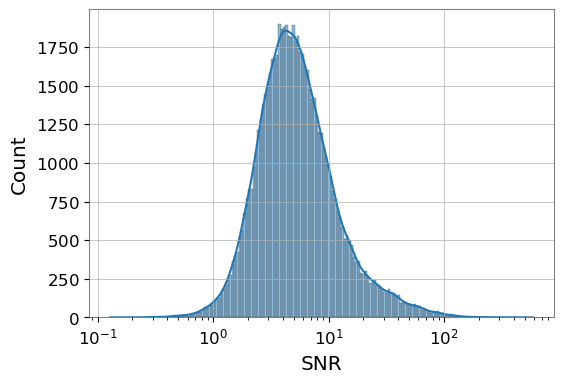

In [5]:
# Plot distribution of SNRs
print(f'There are {sum(signals["SNR"]>15)} signals with SNR>15.')
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.histplot(signals['SNR'], log_scale=(True,False), kde=True, ax=ax)
plt.show()


## Let's produce some template waveform to match our injected signal 

### IMRPhenomD

`IMRPhenomD` is a gravitational waveform model used in the analysis of gravitational wave signals produced by the inspiral, merger, and ringdown of compact binary systems, such as binary black holes or binary neutron stars. This model is an extension of the `IMRPhenom` family of waveform models developed for the LIGO/Virgo Collaboration.

The "IMR" stands for "Inspiral-Merger-Ringdown," which are the three phases of the gravitational wave signal emitted during the coalescence of compact binaries. The "Phenom" part refers to "Phenomenological," indicating that the model is constructed based on a combination of theoretical insights and empirical fits to numerical simulations rather than being derived from first principles.

`IMRPhenomD` incorporates improvements over earlier versions, such as `IMRPhenomC` and `IMRPhenomPv2`, by including more accurate waveform descriptions, particularly in the high-frequency regime where post-Newtonian approximations are less reliable.

### IMRPhenomXPHM
`IMRPhenomXPHM` is a gravitational waveform model used in the analysis of gravitational wave signals originating from the inspiral, merger, and ringdown phases of compact binary systems, such as binary black holes or binary neutron stars. It belongs to the family of `IMRPhenom` waveform models 
 
It incorporates advancements in understanding and modeling of gravitational waveforms, particularly focusing on high-frequency features and the treatment of various physical effects such as precession, higher-order post-Newtonian corrections, and tidal effects in the case of neutron star binaries.

 
While both `IMRPhenomD` and `IMRPhenomXPHM` are phenomenological waveform models used in gravitational wave astronomy, they may differ in their construction, accuracy, coverage of parameter space, and specific modeling assumptions.  

In [6]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD(a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx1 ='IMRPhenomD'
apx2= 'IMRPhenomXPHM'
 
 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [7]:
sample_rate=8192
 
hp1, _ = get_td_waveform(approximant=apx1,
                         mass1=4,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=10)
hp2, _ = get_td_waveform(approximant=apx2,
                         mass1=4,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=10)
 

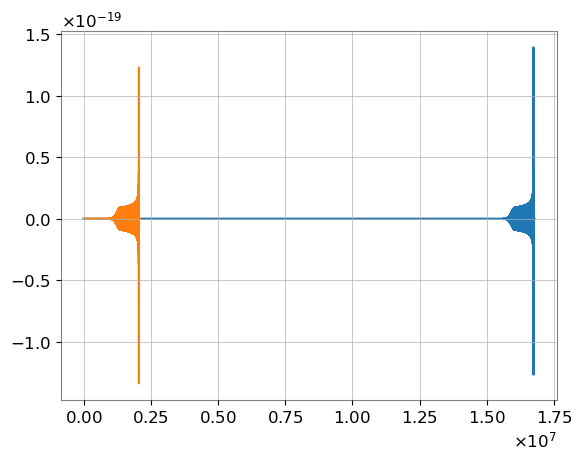

In [8]:
plt.figure()
plt.plot(hp2)
plt.plot(hp1)

 

Inj 42581, tc 1001620463.11925, Masses: (24.386689, 23.987984), chirp length 8.715954576399563 s, SNR 587.553918
Inj 42634, tc 1001622678.23317, Masses: (46.665966, 42.843973), chirp length 2.9100520001258174 s, SNR 386.213044


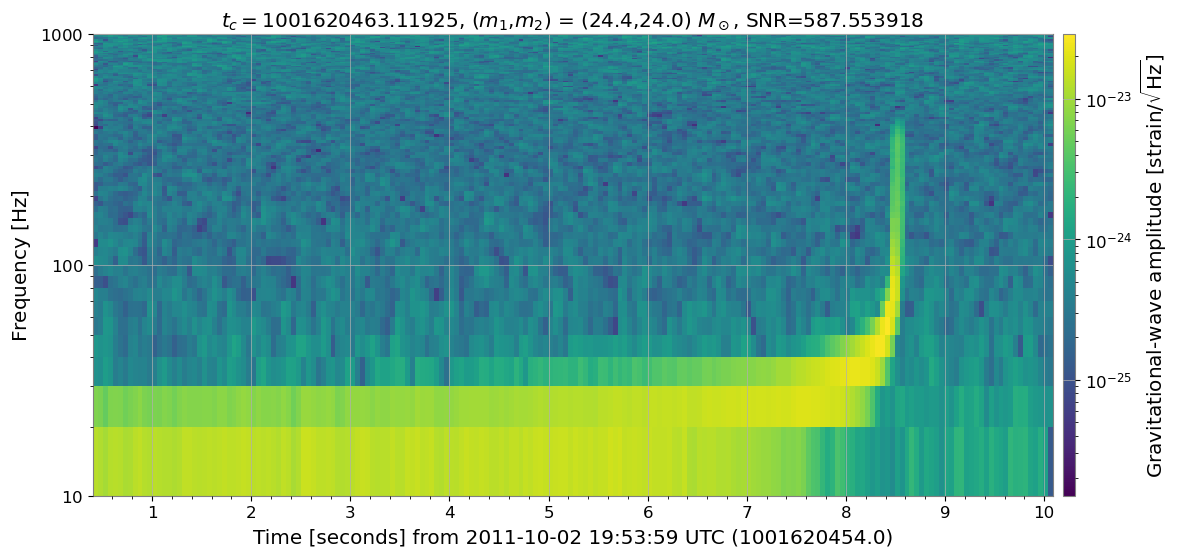

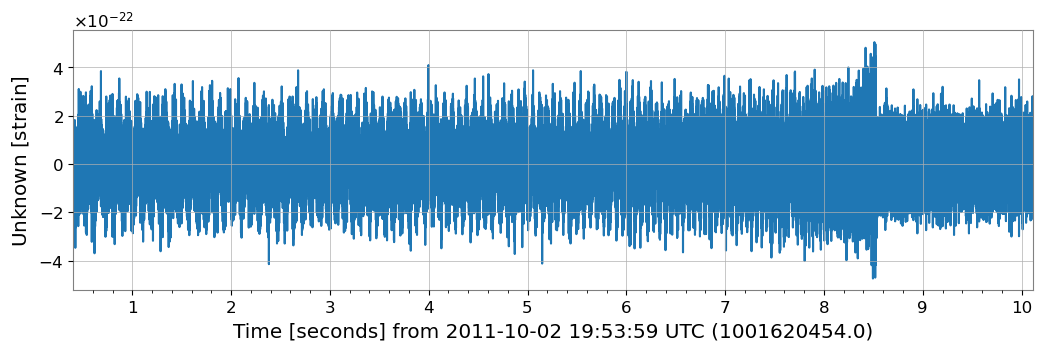

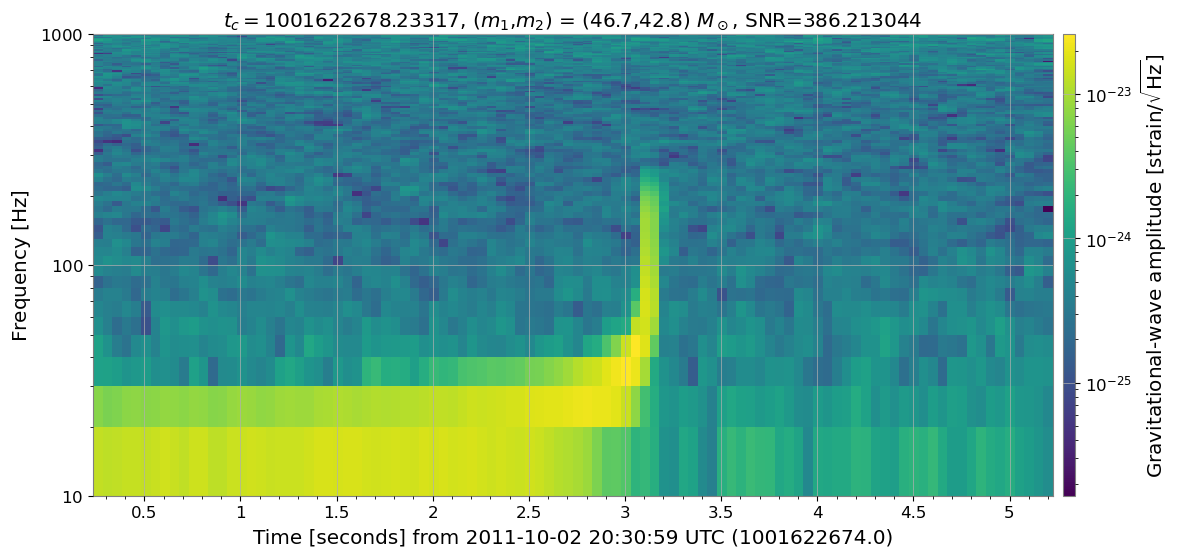

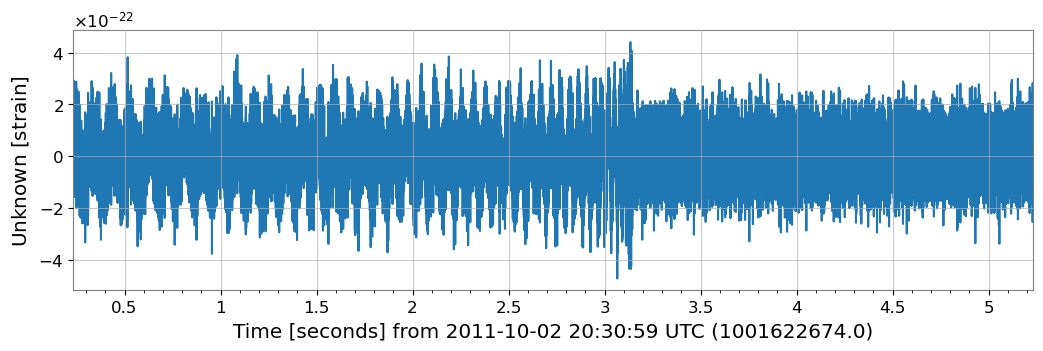

In [9]:
import lal
from lal import MSUN_SI as Msun
from lalsimulation import SimIMRPhenomDChirpTime
# Choose the top few signals to plot
Nplot = 2
top_sigs = signals.iloc[:Nplot]

def read_without_warnings(cachefile, channel, **kwargs):
    """Reads cache file while suppressing spurious LAL warnings.
    Wraps gwpy.timeseries.TimeSeries.read

    Args:
        cachefile (str): path to cache file
        channel (str): Channel name
        **kwargs: additional arguments passed to TimeSeries.read
    """
    prev_level = lal.GetDebugLevel()
    lal.ClobberDebugLevel(0)
    result = TimeSeries.read(cachefile, channel, **kwargs)
    lal.ClobberDebugLevel(prev_level)
    return result

def get_strain(tc, t_before = 4, t_after = 1):
    start_time = tc - t_before
    end_time = tc + t_after
    h = read_without_warnings('../caches/E1.lcf','E1:STRAIN',start=start_time, end=end_time)
    return h

def plot_specgram2(h):
    specgram = h.spectrogram2(fftlength=1/10,overlap=1/50)**(1/2)
    return specgram

for idx, pars in top_sigs.iterrows():
    tc =pars['tc']
    m1 = pars['m1']
    m2 = pars['m2']
    f_min = 10
    chirplen = SimIMRPhenomDChirpTime(pars['m1']*Msun, pars['m2']*Msun, pars['s1z'], pars['s2z'], f_min )
    print(f'Inj {int(pars["#"])}, tc {pars["tc"]}, Masses: {pars["m1"],pars["m2"]}, chirp length {chirplen} s, SNR {pars["SNR"]}')
    h = get_strain(tc, t_before=max(4,min(30,chirplen)))
    sg = h.spectrogram2(fftlength=1/10)**(1/2)
    plot = sg.plot(norm='log', yscale='log',
                   title=f'$t_c={tc}$, ($m_1$,$m_2$) = ({pars["m1"]:.1f},{pars["m2"]:.1f}) $M_\odot$, SNR={pars["SNR"]}',
                   ylim=(10,1000))
    ax = plot.gca()
    ax.colorbar(
        label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]')
    h.plot()
plt.show()

In [28]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
# Shfrom pycbc.waveform import get_fd_waveform
 
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [24]:
import lal
def read_without_warnings(cachefile, channel, **kwargs):
    """Reads cache file while suppressing spurious LAL warnings.
    Wraps gwpy.timeseries.TimeSeries.read

    Args:
        cachefile (str): path to cache file
        channel (str): Channel name
        **kwargs: additional arguments passed to TimeSeries.read
    """
    prev_level = lal.GetDebugLevel()
    lal.ClobberDebugLevel(0)
    result = TimeSeries.read(cachefile, channel, **kwargs)
    lal.ClobberDebugLevel(prev_level)
    return result

def get_strain(tc, t_before = 4, t_after = 1):
    start_time = tc - t_before
    end_time = tc + t_after
    h = read_without_warnings('../caches/E1.lcf','E1:STRAIN',start=start_time, end=end_time)
    return h
 

In [25]:
tc=1001620463.11925
h=get_strain(tc, t_before = 16, t_after = 16)

262144


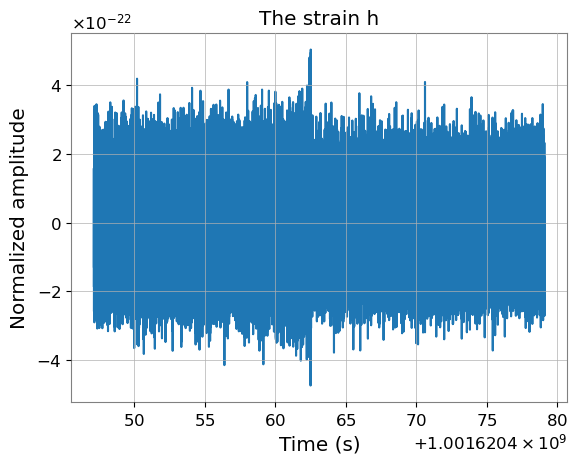

In [26]:
pylab.figure()
pylab.title("The strain h")
pylab.plot( h)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')
print (len(h))

In [32]:
h1 = highpass_fir(h, 15, 8)
 

# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h.duration)


AttributeError: 'TimeSeries' object has no attribute 'delta_t'

In [22]:
h1 = h

# Calculate the noise spectrum
psd = interpolate(welch(h), 1.0 / h1.duration)


AttributeError: 'TimeSeries' object has no attribute 'precision'

In [20]:
# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=24, mass2=23,
                         f_lower=10, delta_f=1.0/h1.duration)
hp.resize(len(h1) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pp.plot(snr.sample_times, abs(snr))
pp.ylabel('signal-to-noise')
pp.xlabel('GPS Time (s)')
pp.show()

NameError: name 'h1' is not defined